# Fashion-MNIST Classification with PyTorch
This notebook implements a neural network to classify Fashion-MNIST dataset using PyTorch. 

## Part 1: NN Model
1. Read the Fashion-MNIST dataset
    - Load and visualize the Fashion-MNIST dataset
    - Preprocess and normalize the data
    - Create a neural network with one hidden layer
    - Train the model
    - Analyze learning curves

In [16]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

# Set random seed for reproducibility
SEED = 42
BATCH_SIZE = 128 # number of nodes in each batch
torch.manual_seed(SEED)
print(f"Random Seed: {SEED}")
print(f"Batch Size: {BATCH_SIZE}")

# Check if MPS (Metal Performance Shaders) is available for Mac GPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"MPS built: {torch.backends.mps.is_built()}")

# Function to display images
def imshow(img, title=None):
    plt.imshow(np.transpose(img, (1, 2, 0)), cmap='gray')
    if title is not None:
        plt.title(title)

Random Seed: 42
Batch Size: 128
Using device: mps
PyTorch version: 2.5.1
MPS available: True
MPS built: True


- Download the datasets
- Setup the splits
- Loat the data into dataloaders
- Define the classes (first guess of what fashion products)
- Display some of the products

Size of training set: 60000
Size of test set: 10000
Size of training split: 48000: 80%
Size of validation split: 12000: 20%
Size of image 0: torch.Size([1, 28, 28])


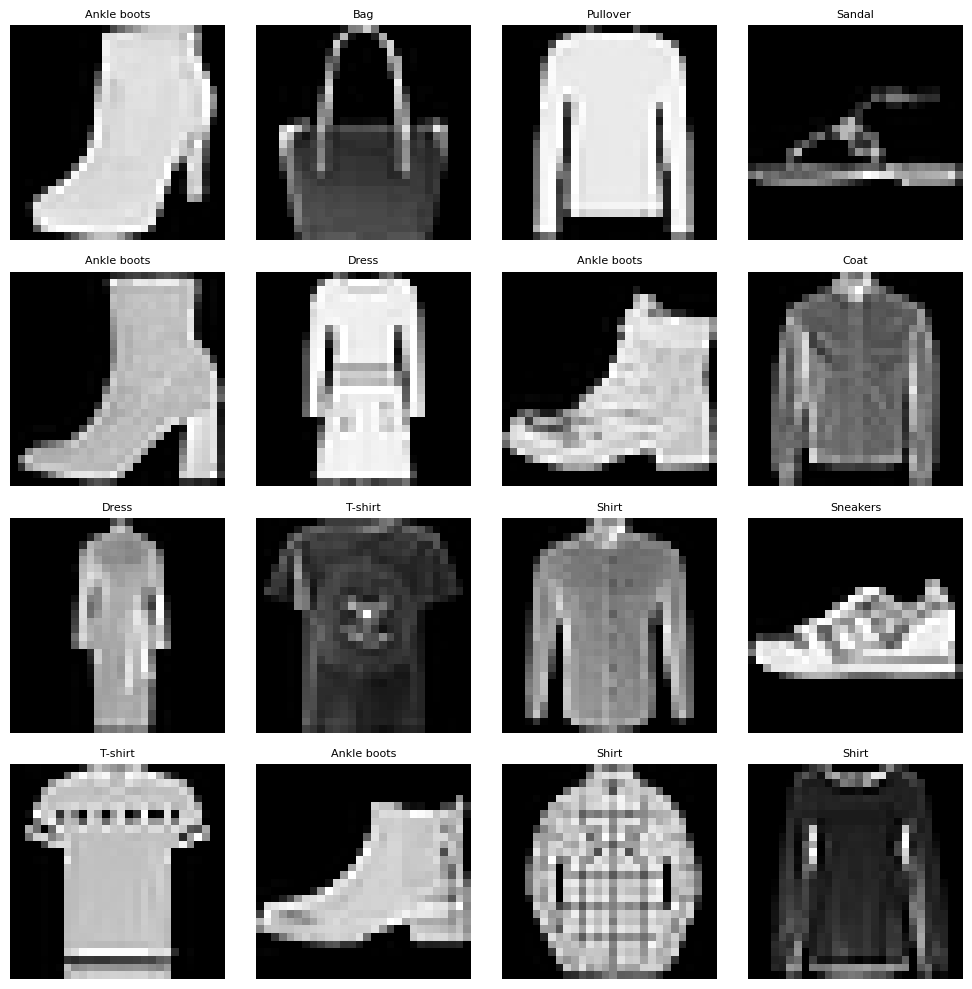

In [19]:
# Load Fashion-MNIST dataset and normalize the data from [0, 255] for b&w images to [0, 1]
transform = transforms.ToTensor()  

trainset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
    )
print(f'Size of training set: {len(trainset)}')

testset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform
)
print(f'Size of test set: {len(testset)}')

# Validation and training split 
batch_size = BATCH_SIZE
train_size = int(0.8 * len(trainset))  # 80% for training
val_size = len(trainset) - train_size   # 20% for validation
print(f'Size of training split: {train_size}: 80%')
print(f'Size of validation split: {val_size}: 20%')

# Splitting the datasets
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Load the data into DataLoaders. 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# Define the classes
classes = [
    'T-shirt', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneakers', 'Bag', 'Ankle boots'
    ]
NUM_CLASSES = len(classes)

# Get some random training images
# Convert to iterator and get next batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Create a grid of images
num_images = 16 # per instructions
fig = plt.figure(figsize=(10, 10))
counter = True
for i in range(num_images):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.axis('off')
    imshow(images[i])
    ax.set_title(classes[labels[i]], fontsize=8)
    if counter:
        print(f"Size of image {i}: {images[i].shape}")
        height, width = images[i].shape[1], images[i].shape[2]
        counter = False
plt.tight_layout()
plt.show()

- Create a simple model

In [20]:
# Define the neural network class
class FashionMNISTNet(nn.Module):
    # Instanciate in the constructor
    def __init__(self):
        super(FashionMNISTNet, self).__init__()
        self.flatten = nn.Flatten() # flattens the images
        # Use height and width obtained from the images
        self.fc1 = nn.Linear(height * width, 128) # Input layer -> Hidden layer (128 nodes)
        self.relu = nn.ReLU() # add non-linearity
        self.fc2 = nn.Linear(128, NUM_CLASSES) # Hidden layer -> Output layer (10 classes)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Create the model and move it to device
model = FashionMNISTNet().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [21]:
# Training loop
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Training phase
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

Epoch [1/20], Train Loss: 0.6323, Train Acc: 78.61%, Val Loss: 0.4699, Val Acc: 83.88%
Epoch [2/20], Train Loss: 0.4381, Train Acc: 84.55%, Val Loss: 0.4120, Val Acc: 85.56%
Epoch [3/20], Train Loss: 0.3940, Train Acc: 86.15%, Val Loss: 0.3757, Val Acc: 87.01%
Epoch [4/20], Train Loss: 0.3690, Train Acc: 86.94%, Val Loss: 0.3673, Val Acc: 87.13%
Epoch [5/20], Train Loss: 0.3456, Train Acc: 87.67%, Val Loss: 0.3416, Val Acc: 87.66%
Epoch [6/20], Train Loss: 0.3303, Train Acc: 88.22%, Val Loss: 0.3488, Val Acc: 87.42%
Epoch [7/20], Train Loss: 0.3144, Train Acc: 88.65%, Val Loss: 0.3561, Val Acc: 87.64%
Epoch [8/20], Train Loss: 0.3033, Train Acc: 89.07%, Val Loss: 0.3418, Val Acc: 87.69%
Epoch [9/20], Train Loss: 0.2919, Train Acc: 89.46%, Val Loss: 0.3098, Val Acc: 88.67%
Epoch [10/20], Train Loss: 0.2828, Train Acc: 89.65%, Val Loss: 0.3093, Val Acc: 88.96%
Epoch [11/20], Train Loss: 0.2719, Train Acc: 90.09%, Val Loss: 0.3105, Val Acc: 88.89%
Epoch [12/20], Train Loss: 0.2640, Train 

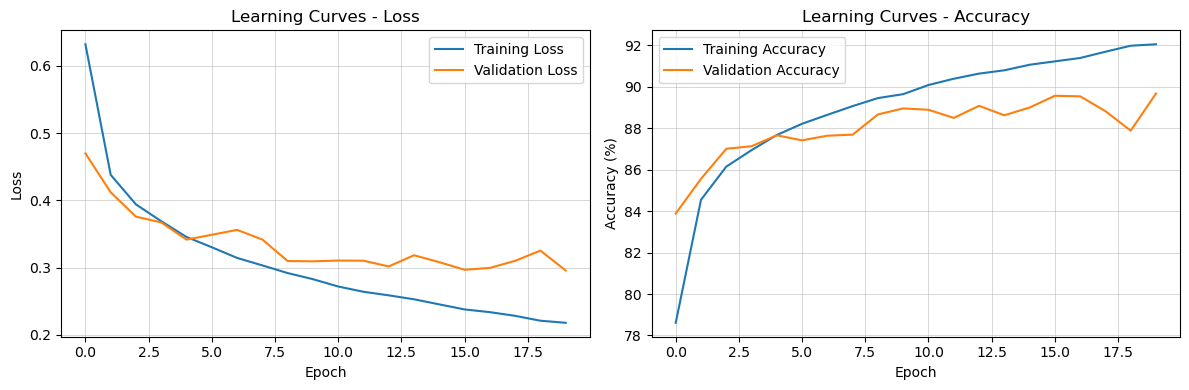

In [24]:
# Plot learning curves
plt.figure(figsize=(12, 4))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Learning Curves - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(linewidth=0.5, alpha=0.7)


# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Learning Curves - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

# Analysis of Learning Curves

When examining the learning curves, we should look for:

1. **Convergence**: Are both training and validation losses decreasing?
2. **Overfitting**: Is there a growing gap between training and validation performance?
3. **Learning Rate**: Is the model learning too slowly or too quickly?

Common issues and solutions:
- If validation loss increases while training loss decreases → Overfitting
  - Solution: Add dropout, reduce model complexity, or use regularization
- If both losses plateau too early → Learning rate might be too high
  - Solution: Reduce learning rate or use learning rate scheduling
- If both losses decrease very slowly → Learning rate might be too low
  - Solution: Increase learning rate